In [11]:
#Excercise 01
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('... loading data')
with open('mnist.pkl', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

... loading data


In [12]:
train_x, train_y = train_set
test_x, test_y = test_set

train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y, columns=['label'])
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y, columns=['label'])

In [13]:
from sklearn.decomposition import PCA

PCA_model=PCA(n_components=2).fit(train_x)
PCA_train_x=PCA_model.transform(train_x)
PCA_test_x=PCA_model.transform(test_x)

In [14]:
print('PCA_train_x shape: ', PCA_train_x.shape)
print('PCA_test_x shape: ', PCA_test_x.shape)

PCA_train_x shape:  (50000, 2)
PCA_test_x shape:  (10000, 2)


Text(0, 0.5, 'Principal Component 2')

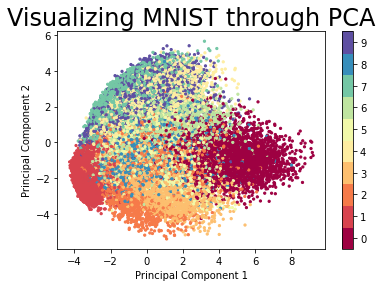

In [15]:
#Plot on the graph
plt.scatter(PCA_train_x[:,0],PCA_train_x[:,1],s=5,c=train_y['label'],cmap='Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

plt.title('Visualizing MNIST through PCA', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [16]:
sub_PCA_train_x = PCA_train_x[:1000,:]
print('sub_PCA_train_x.shape: ', sub_PCA_train_x.shape)

sub_PCA_train_x.shape:  (1000, 2)


In [17]:
sub_PCA_test_x = PCA_test_x[:100,:]
print('sub_PCA_test_x.shape: ', sub_PCA_test_x.shape)

sub_PCA_test_x.shape:  (100, 2)


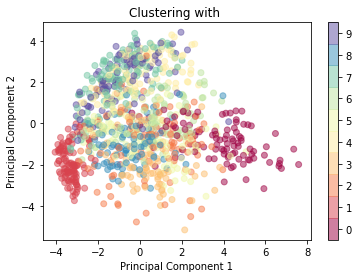

In [21]:
#Exercise 02
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

hier = AgglomerativeClustering(n_clusters=10,affinity='euclidean')
hier_clusters=hier.fit(sub_PCA_train_x)

# Plot 
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c=train_y['label'][:1000], cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("Clustering with ")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [42]:
#Exercise 03

#3-1 Normalize data

a = np.array([1, 3, 4])
A = np.tile(a, (3,1))
A

array([[1, 3, 4],
       [1, 3, 4],
       [1, 3, 4]])

In [43]:
def apply_normalizer(dataset, offset, divisor):
    dataset_normalized = np.zeros(dataset.shape)
    N = dataset.shape[0]
    dataset_normalized = dataset-np.tile(offset,(N,1))
    dataset_normalized = dataset_normalized/np.tile(divisor,(N,1))
    return dataset_normalized


def normalize_minmax(dataset):
    minval = dataset.min(0)
    maxval = dataset.max(0)
    dataset_normalized = apply_normalizer(dataset,minval,maxval-minval)
    return dataset_normalized, minval, maxval-minval


def normalize_meanstd(dataset):
    meanval = dataset.mean(0)
    stdval = dataset.std(0)
    dataset_normalized = apply_normalizer(dataset,meanval,stdval)
    return dataset_normalized, meanval, stdval

In [44]:
normalized_PCA_train_x, off, div = normalize_minmax(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div, '\n')

normalized_PCA_train_x, off, div = normalize_meanstd(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div)

Original data:  [ 0.46151078 -1.246866  ] 
Normalized data:  [0.3881965  0.40918162]
offset: [-4.0606465 -5.1655498] ;  divisor: [11.649145  9.576881] 

Original data:  [ 0.46151078 -1.246866  ] 
Normalized data:  [ 0.24438669 -0.6387503 ]
offset: [-0.07587934 -0.00492787] ;  divisor: [2.1989336 1.9443249]


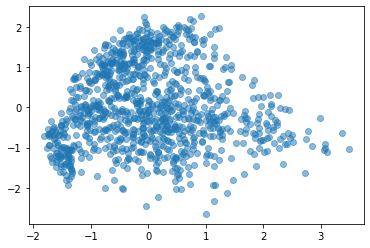

In [45]:
plt.scatter(normalized_PCA_train_x[:, 0], normalized_PCA_train_x[:, 1], cmap='Spectral', alpha=0.5)

In [46]:
# a distance function
def Euclidean_distance(vecA, vecB):
    return np.sqrt(sum(np.power([a-b for a,b in zip(vecA,vecB)],2)))

In [47]:
#3-2 Initialize centroids

k = int(input("How many cluster do you want? "))
print(k)

How many cluster do you want? 10
10


In [61]:
import random

def init_centroids_random(dataset, k):
    centroids={}
    init_centroids = random.sample(range(0,len(dataset)),k)
    for i,c in enumerate(init_centroids):
        centroids[i]=dataset[i]
    return centroids

In [62]:
def init_centroids_index(dataset, k):
    centroids={}
    for i in range(k):  # first k instances become the initial centroids
        centriods[i]=dataset[i]
    return centroids

In [63]:
# initialize_centroids(centroids, sub_PCA_train_x)
centroids = init_centroids_random(sub_PCA_train_x, k)

In [64]:
#Change centroids value to dataframe. 
cet_df = pd.DataFrame(centroids).transpose()
cet_df.columns=['X','Y']
cet_df.head()

,X,Y
0,0.461511,-1.246866
1,3.921652,-1.251660
2,-0.203711,1.547885
3,-3.148448,-2.296122
4,-1.442681,2.872078


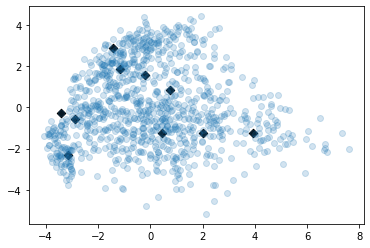

In [72]:
#Plot random centroids on the dataset
plt.figure()
plt.scatter(cet_df['X'],cet_df['Y'],color='black',marker='D')
plt.scatter(sub_PCA_train_x[:,0],sub_PCA_train_x[:,1],alpha=0.2)

In [123]:
#3-3 (Re)Assigning every datas to its closest centroid

def re_assign_data(dataset, centroids):
    cluster_memberships={}
    for i in centroids:
        cluster_memberships[i]=[]
    
    for row in dataset:
        # Calculate euclidean distance between each centroid and each data.
        dist_to_centroids = [Euclidean_distance(row,centroids[c]) for c in centroids]
        
        # Find the centroid with a minimum distance 
        membership = dist_to_centroids.index(min(dist_to_centroids))
        cluster_memberships[membership].append(row)
    return cluster_memberships

In [127]:
#3-4 Recalculate average of each cluster and calculate SSE value

def re_cal_avg_sse(centroids, cluster_memberships):
    curr_sse=0
    
    # Re-calculate the average of each cluster and calculate SSE.
    for membership in cluster_memberships:
        centroids[membership] = np.average(cluster_memberships[membership],axis=0)

        for row in cluster_memberships[membership]:
            curr_sse += np.power(Euclidean_distance(row,centroids[membership]),2)
    
    return centroids, curr_sse      

In [128]:
#3-5 Iterate step3(#3-3) and step4(3-4) until SSE is less than 'tol' value

## k-Means algorithm
def kmeans(dataset, k, max_iter = 300, tol = 0.001):
    centroids=init_centroids_random(dataset,k)
    
    ## 1. Initiate SSE which is key metric in k-means clustering (sse = sum of squared error) into 'np.inf'
    curr_sse = np.inf

    ## 2. Clustering
    for i in range(max_iter):

        ## (Re)Aassign datas to its closest centroids
        cluster_memberships=re_assign_data(dataset,centroids)

        prev_sse = curr_sse
        ## Re-calculate the average of each cluster and calculate SSE.
        centroids,curr_sse=re_cal_avg_sse(centroids,cluster_memberships)

        ## Plot center points
        plt.figure(i)
        c_df = pd.DataFrame(centroids).transpose()
        plt.scatter(c_df.loc[:, 0], c_df.loc[:, 1], color='black', marker='x')

        ## Plot assigned data
        for key in cluster_memberships:
            plt.scatter(*zip(*cluster_memberships[key]), alpha=0.2)
            plt.title('k={} '.format(k) + ' SSE=' + str(curr_sse))

        plt.show()
        print('iteration#{} | prev_sse= {:.4f};  curr_sse= {:.4f}'.format(i, prev_sse, curr_sse))

        # Terminal Condition
        if (prev_sse - curr_sse) / curr_sse < tol:
            break

    return cluster_memberships, curr_sse

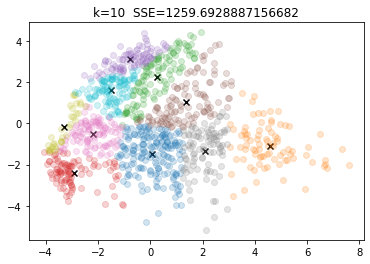

iteration#0 | prev_sse= inf;  curr_sse= 1259.6929


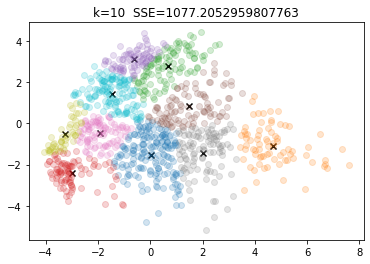

iteration#1 | prev_sse= 1259.6929;  curr_sse= 1077.2053


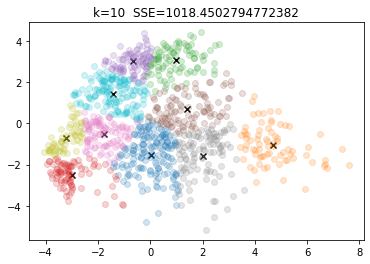

iteration#2 | prev_sse= 1077.2053;  curr_sse= 1018.4503


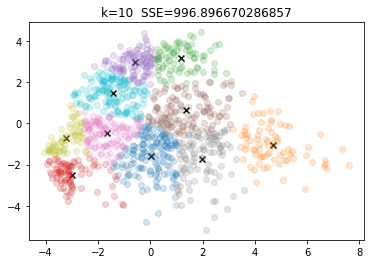

iteration#3 | prev_sse= 1018.4503;  curr_sse= 996.8967


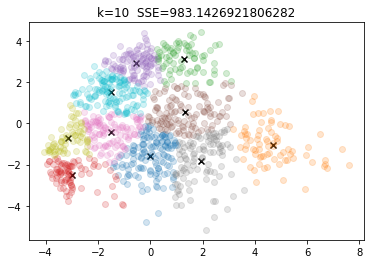

iteration#4 | prev_sse= 996.8967;  curr_sse= 983.1427


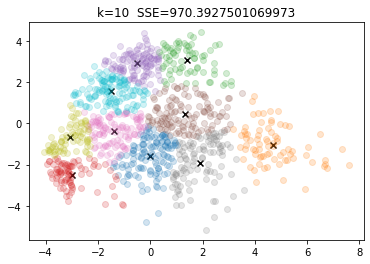

iteration#5 | prev_sse= 983.1427;  curr_sse= 970.3928


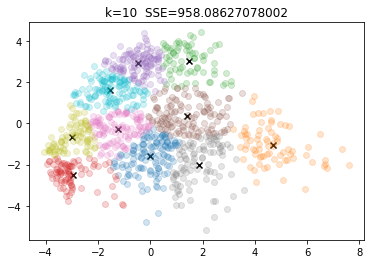

iteration#6 | prev_sse= 970.3928;  curr_sse= 958.0863


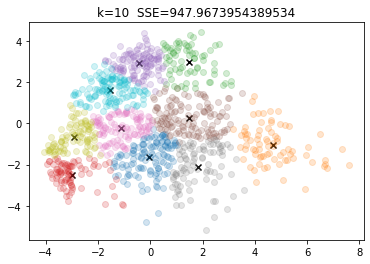

iteration#7 | prev_sse= 958.0863;  curr_sse= 947.9674


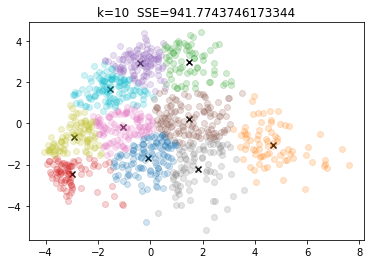

iteration#8 | prev_sse= 947.9674;  curr_sse= 941.7744


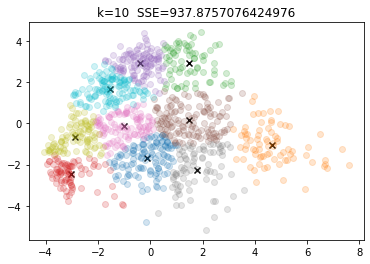

iteration#9 | prev_sse= 941.7744;  curr_sse= 937.8757


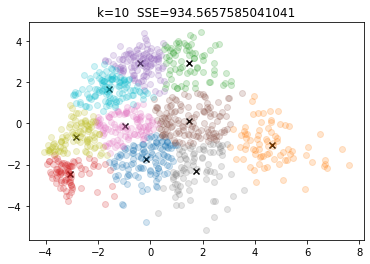

iteration#10 | prev_sse= 937.8757;  curr_sse= 934.5658


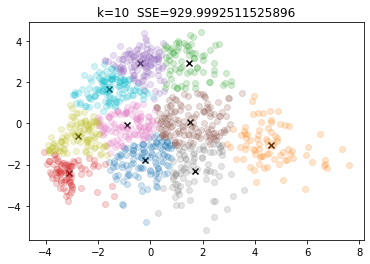

iteration#11 | prev_sse= 934.5658;  curr_sse= 929.9993


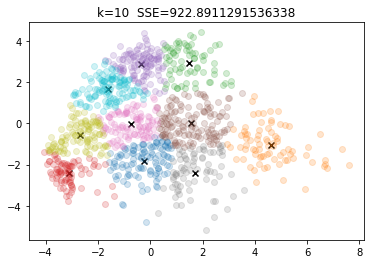

iteration#12 | prev_sse= 929.9993;  curr_sse= 922.8911


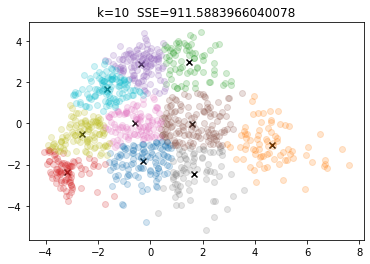

iteration#13 | prev_sse= 922.8911;  curr_sse= 911.5884


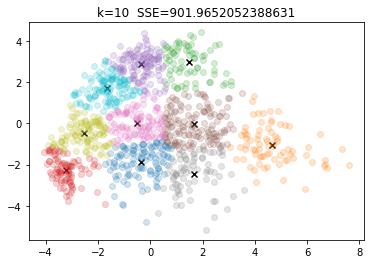

iteration#14 | prev_sse= 911.5884;  curr_sse= 901.9652


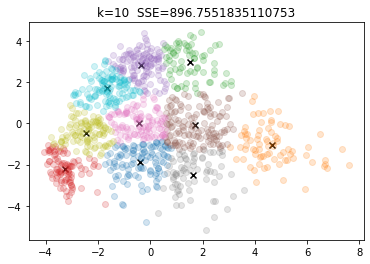

iteration#15 | prev_sse= 901.9652;  curr_sse= 896.7552


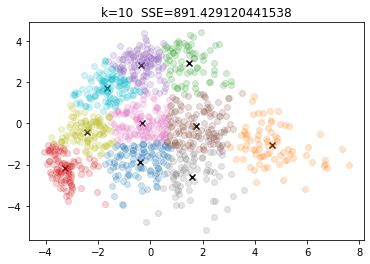

iteration#16 | prev_sse= 896.7552;  curr_sse= 891.4291


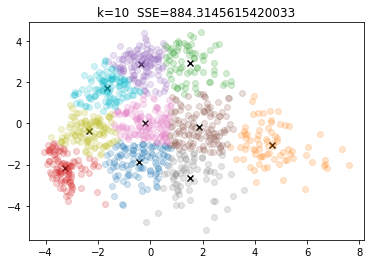

iteration#17 | prev_sse= 891.4291;  curr_sse= 884.3146


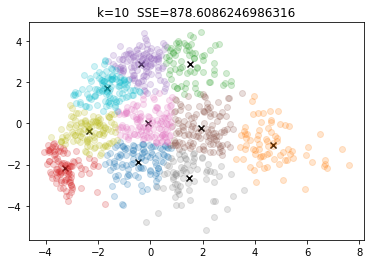

iteration#18 | prev_sse= 884.3146;  curr_sse= 878.6086


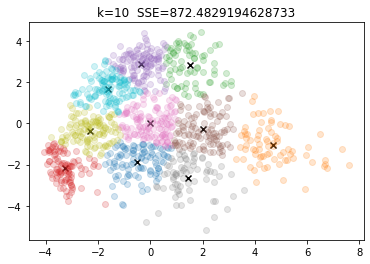

iteration#19 | prev_sse= 878.6086;  curr_sse= 872.4829


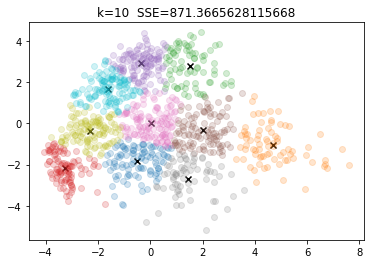

iteration#20 | prev_sse= 872.4829;  curr_sse= 871.3666


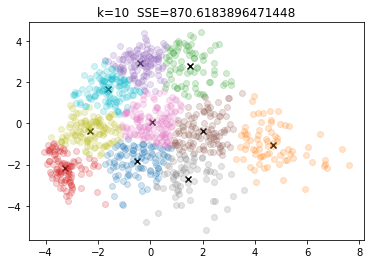

iteration#21 | prev_sse= 871.3666;  curr_sse= 870.6184


In [129]:
cluster_memberships,curr_sse=kmeans(sub_PCA_train_x,k)

In [130]:
#3-6 Using sklearn library

from sklearn.cluster import KMeans
model = KMeans(n_clusters=k)
model.fit(PCA_train_x)

result = model.predict(PCA_test_x)

In [132]:
import pandas as pd

df = pd.DataFrame({'labels':test_y['label'],'result':result})
ct = pd.crosstab(df['labels'],df['result'])
ct

result,0,1,2,3,4,5,6,7,8,9
labels,,,,,,,,,,
0,0,73,217,0,0,470,1,6,7,206
1,0,1,0,1024,3,0,72,35,0,0
2,11,223,156,35,251,18,62,206,7,63
3,5,101,146,12,427,3,57,244,1,14
4,385,26,0,6,0,0,174,4,360,27
5,36,263,184,11,72,13,116,125,10,62
6,23,324,82,11,16,21,53,103,52,273
7,501,25,0,22,1,0,234,21,217,7
8,30,286,85,11,77,31,64,323,20,47


In [ ]:
#Q1: In the normalization methods, what is the meaning of offset and divisor, respectively?
#offsest makes the dataset show the differences between each data in the dataset compared to the ones in the offset.
#divisor is the one which decides the scale of the data being offered.

In [ ]:
#Q2: After normalization, how does the data range change?
#After the normalization, the range of the data ajusts to the common scale without changing the existing range.

In [ ]:
#Q3: Before the iterations, how are the centroids defined?
#Before the interations, the centroids are defined randomly by the random.sample method.

In [ ]:
#Q4: One metric to evaluate the clustering results is sum of squared error(SSE).
#Describe the meaning of SSE in terms of the relationship between data and centroids.
#SSE or also known as sum of squared error is related to both data and centroids. This is because sse is the factor that is decided by the differences of a data and it's centroid.

In [ ]:
#Q5: What is the terminal condition? Describe it with tol and max_iter.
#There are two terminal conditions for the method. First is to either iterate the for loop up until it reaches the max_iter which is 300. Or stop when the sse value is lower than tol, which is 0.001.